In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from utils.help_func import create_path, print_var_detail
class SegmentationNpyDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([
            f for f in os.listdir(images_dir) if f.endswith('.npy')
        ])
        self.mask_files = sorted([
            f for f in os.listdir(masks_dir) if f.endswith('.npy')
        ])
        assert len(self.image_files) == len(self.mask_files), "Mismatch between image and mask counts"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = np.load(os.path.join(self.images_dir, self.image_files[idx]))  # [3, 224, 224]
        mask = np.load(os.path.join(self.masks_dir, self.mask_files[idx]))     # [1, 224, 224]

        image = torch.from_numpy(image).float()  # [3, H, W]
        mask = torch.from_numpy(mask).long()     # [1, H, W]
        return image, mask

# === Initialize datasets ===
train_dataset = SegmentationNpyDataset(
    "./finetune_data/skull_strip/train/images",
    "./finetune_data/skull_strip/train/masks"
)
test_dataset = SegmentationNpyDataset(
    "./finetune_data/skull_strip/test/images",
    "./finetune_data/skull_strip/test/masks"
)

# === Create DataLoaders ===
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
dataloader_val = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [2]:
images, masks = next(iter(dataloader_val))
image_tensor = images

 is a  <class 'torch.Tensor'> with shape torch.Size([3, 224, 224]) max:  tensor(1.) min:  tensor(0.)


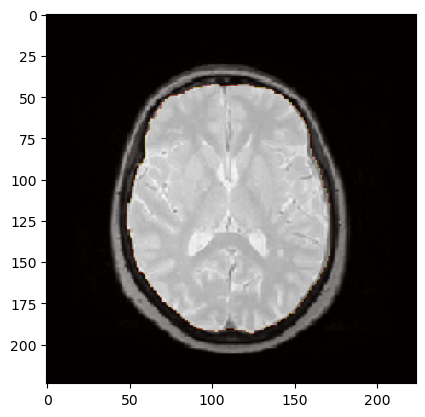

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
target_class = 1
plot_index = 0
print_var_detail(image_tensor[plot_index])
plt.imshow(image_tensor[plot_index].to(dtype=torch.float32).permute(1, 2, 0), cmap='gray')
plt.imshow((masks[plot_index] ==  target_class).permute(1, 2, 0), cmap='hot', alpha=0.4)
plt.show()

In [7]:
from multi_seg.models_mae_finetune_seg import MaskedAutoencoderViTMultiSeg
from functools import partial
import torch
import torch.nn as nn
mode = 'mae_unet_fuse'
INPUT_SIZE = 224
mae_model = MaskedAutoencoderViTMultiSeg(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), num_classes=2, mode=mode,
                 drop=0.1, attn_drop=0.1, drop_path=0.05)

pretrain_path = "./saved_models/mae_vit_base_patch16_pretrain_test0.75_E30/model_E30.pt"

missing, unexpected = mae_model.load_state_dict(torch.load(pretrain_path)['model_state_dict'], strict=False)  # strict=False ignores unmatched keys
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
block = mae_model.decoder_blocks  # pick any block you want

num_params = sum(p.numel() for p in block.parameters())
trainable_params = sum(p.numel() for p in block.parameters() if p.requires_grad)
from multi_seg.mae_unet_fuse import UnetWithMAEFusion
from modeling.unet import Unet
CHANS = 64
unet_model = Unet(in_chans=3,out_chans=2, chans=CHANS, if_classify= False,  dim=INPUT_SIZE, mlp_ratio = 32)
model = UnetWithMAEFusion(unet=unet_model, mae_model=mae_model, custom_fusion_modes=['concat', 'concat', 'concat', 'concat', 'concat', 'concat', 'concat', 'concat', 'concat'], mae_indices = [0, 2, 5, 8, 11, 8, 5, 2, 0], skip_connect = True, skip_type = 'concat')
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(next(model.parameters()).dtype)
missing, unexpected = mae_model.load_state_dict(torch.load(pretrain_path)['model_state_dict'], strict=False)  # strict=False ignores unmatched keys

Missing keys: []
Unexpected keys: []
150088194
149836034
torch.float32


In [8]:
from multi_seg.dice_loss_seg import CombinedGDLFocalCELoss, softmax_helper
from multi_seg.dice_loss_seg import CombinedDiceFocalCELoss, softmax_helper
# gdl Loss settings
gdl_kwargs = {
    'apply_nonlin': softmax_helper,   # apply softmax inside
    'batch_dice': False,              # per sample Dice
    'do_bg': True,                    # include background (class 0)
    'smooth': 1e-5,                    # smoothing factor
    'square': False,
    'square_volumes': False,
}

# Dice Loss settings
dice_kwargs = {
    'apply_nonlin': softmax_helper,  # Apply softmax inside DiceLoss
    'batch_dice': False,              # Per-sample dice (not batch-level)
    'do_bg': True,                    # Include background class
    'smooth': 1e-5                    # Smoothing factor
}

# Focal Loss settings
focal_kwargs = {
    'gamma': 2.0,
    'alpha': 0.25,
    'reduction': 'mean',
    'apply_nonlin': softmax_helper    # Apply softmax inside FocalLoss too
}

# CrossEntropy Loss settings
ce_kwargs = {
    'reduction': 'mean'
}

# (Optional) Weights for each sub-loss (dice, focal, ce)
weights = (1.0, 1.0, 1.0)

# Initialize loss
loss_fn = CombinedGDLFocalCELoss(
    gdl_kwargs=gdl_kwargs,
    focal_kwargs=focal_kwargs,
    ce_kwargs=ce_kwargs,
    weights=weights
) # this kind of works, but will cause negative loss, probably caused by GDL

# loss_fn = CombinedDiceFocalCELoss(
#     dice_kwargs=dice_kwargs,
#     focal_kwargs=focal_kwargs,
#     ce_kwargs=ce_kwargs,
#     weights=weights
# )

# loss_fn = nn.CrossEntropyLoss(
#     reduction='mean'
# )

import torch.optim as optim

# ---- Optimizer ----
lr = 1e-4
weight_decay= 1e-2
optimizer = optim.AdamW(
    model.parameters(), 
    lr=lr, 
    weight_decay=weight_decay
)


In [9]:
from multi_seg.train_mae_finetune_seg import Trainer
freeze_mae_encoder = True
freeze_mae_encoder_decoder = True
force_float32 = False
TRAIN_EPOCHS = 1000
freeze_start_epoch = None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if freeze_mae_encoder:
    if freeze_mae_encoder_decoder:
        path_save = "../saved_models/skull_strip/syn_freeze_E_D" +"_mae_unet"+ str(CHANS) + "concat_" + mode + "_" + "_e" + str(TRAIN_EPOCHS) +  '/'
    else:
        path_save = "../saved_models/skull_strip/syn_freeze_E" + "_mae_unet"+ str(CHANS) + "concat_" + mode + "_" + "_e" + str(TRAIN_EPOCHS) +  '/'
else: # use 
    path_save = "../saved_models/skull_strip/syn_unfreeze" + "_mae_unet"+ str(CHANS) + "concat_" + mode +  "_e" + str(TRAIN_EPOCHS) +  '/'

create_path(path_save)
trainer = Trainer(
    loader_train=dataloader_train,      # your training DataLoader
    loader_test=dataloader_val,        # your test/validation DataLoader
    my_model=model,                 # your MaskedAutoencoderViTMultiSeg model
    my_loss=loss_fn,
    optimizer=optimizer,
    RESUME_EPOCH=0,                 # set >0 if you load checkpoints
    PATH_MODEL=path_save,    # where you want to save checkpoints
    device=device,                  # or 'cuda:0', depending on your setup
    task='segment',                 # since you are doing segmentation
    freeze_mae_encoder=freeze_mae_encoder,       # if you want to freeze encoder
    freeze_mae_encoder_decoder=freeze_mae_encoder_decoder,  # if you want to freeze encoder+decoder
    force_float32 = force_float32,
    unfreeze_at_epoch = freeze_start_epoch,
    weight_decay=weight_decay,
    num_classes= 2,
)


The new directory is created!


In [10]:
model = trainer.train(epochs=TRAIN_EPOCHS, show_step=200, show_test=True)

MAE freeze mode is enabled: True
Total params: 150088194
Trainable params: 38180354


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

images_input is a  <class 'torch.Tensor'> with shape torch.Size([32, 3, 224, 224]) max:  tensor(1., device='cuda:0') min:  tensor(0., device='cuda:0')
images type: torch.float32
labels_input is a  <class 'torch.Tensor'> with shape torch.Size([32, 224, 224]) max:  tensor(1, device='cuda:0') min:  tensor(0, device='cuda:0')
labels type: torch.int64
logits is a  <class 'torch.Tensor'> with shape torch.Size([32, 2, 224, 224]) max:  tensor(1.2343, device='cuda:0', grad_fn=<MaxBackward1>) min:  tensor(-1.0230, device='cuda:0', grad_fn=<MinBackward1>)
logits type: torch.float32
⏱️ Batch 0 time: 2.2702 seconds
⏱️ Batch 1 time: 0.8139 seconds
⏱️ Batch 2 time: 0.7374 seconds
⏱️ Batch 3 time: 0.7814 seconds
⏱️ Batch 4 time: 0.7877 seconds
⏱️ Batch 5 time: 0.2319 seconds
MODEL SAVED at epoch 1
MODEL SAVED at epoch 200
MODEL SAVED at epoch 400
MODEL SAVED at epoch 600
MODEL SAVED at epoch 800
MODEL SAVED at epoch 1000


Testing:   0%|          | 0/625 [00:00<?, ?it/s]

### TEST LOSS: 0.291444 || Accuracy (excluding background): 96.75% || Correct: 183138607 / 189288691
----------------------------------------------------------------------
Per-class Dice and IoU (excluding background):
Class 1: Dice 0.9694 || IoU 0.9406
Mean Dice (excluding background): 0.9694
Mean IoU (excluding background): 0.9406


In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_with_input(images, logits, gt_masks, selected_classes=None, max_plots=4):
    """
    Args:
        images: (B, 3, 224, 224) input images (grayscale replicated to 3 channels)
        logits: (B, 14, 224, 224) model output logits
        gt_masks: (B, 1, 224, 224) ground truth masks
        selected_classes: list of class indices to show (excluding background 0), e.g., [1,2,3]
        max_plots: how many samples to plot
    """
    preds = torch.softmax(logits, dim=1)
    preds = torch.argmax(preds, dim=1)  # (B, 224, 224)

    batch_size = images.size(0)
    max_plots = min(max_plots, batch_size)

    imgs = images.detach().cpu()
    preds = preds.cpu()
    gts = gt_masks.squeeze(1).cpu()

    fig, axs = plt.subplots(max_plots, 3, figsize=(15, 5 * max_plots))

    if max_plots == 1:
        axs = [axs]  # ensure iterable

    for idx in range(max_plots):
        img = imgs[idx, 0]  # assuming grayscale is in channel 0
        img = (img - img.min()) / (img.max() - img.min())  # normalize for display

        pred_mask = preds[idx].numpy()
        gt_mask = gts[idx].numpy()

        # Mask selection
        if selected_classes is not None:
            pred_mask = np.where(np.isin(pred_mask, selected_classes), pred_mask, 0)
            gt_mask = np.where(np.isin(gt_mask, selected_classes), gt_mask, 0)

        pred_mask_masked = np.ma.masked_where(pred_mask == 0, pred_mask)
        gt_mask_masked = np.ma.masked_where(gt_mask == 0, gt_mask)

        # --- Input MRI
        axs[idx][0].imshow(img, cmap='gray')
        axs[idx][0].set_title(f"Input MRI (Image {idx})")
        axs[idx][0].axis('off')

        # --- Prediction
        axs[idx][1].imshow(img, cmap='gray')
        axs[idx][1].imshow(pred_mask_masked, cmap='jet', alpha=0.5, vmin=1, vmax=13)
        axs[idx][1].set_title(f"Prediction Overlay (Image {idx})")
        axs[idx][1].axis('off')

        # --- Ground truth
        axs[idx][2].imshow(img, cmap='gray')
        axs[idx][2].imshow(gt_mask_masked, cmap='jet', alpha=0.5, vmin=1, vmax=13)
        axs[idx][2].set_title(f"Ground Truth Overlay (Image {idx})")
        axs[idx][2].axis('off')

    plt.tight_layout()
    plt.show()
    return pred_mask_masked, gt_mask_masked


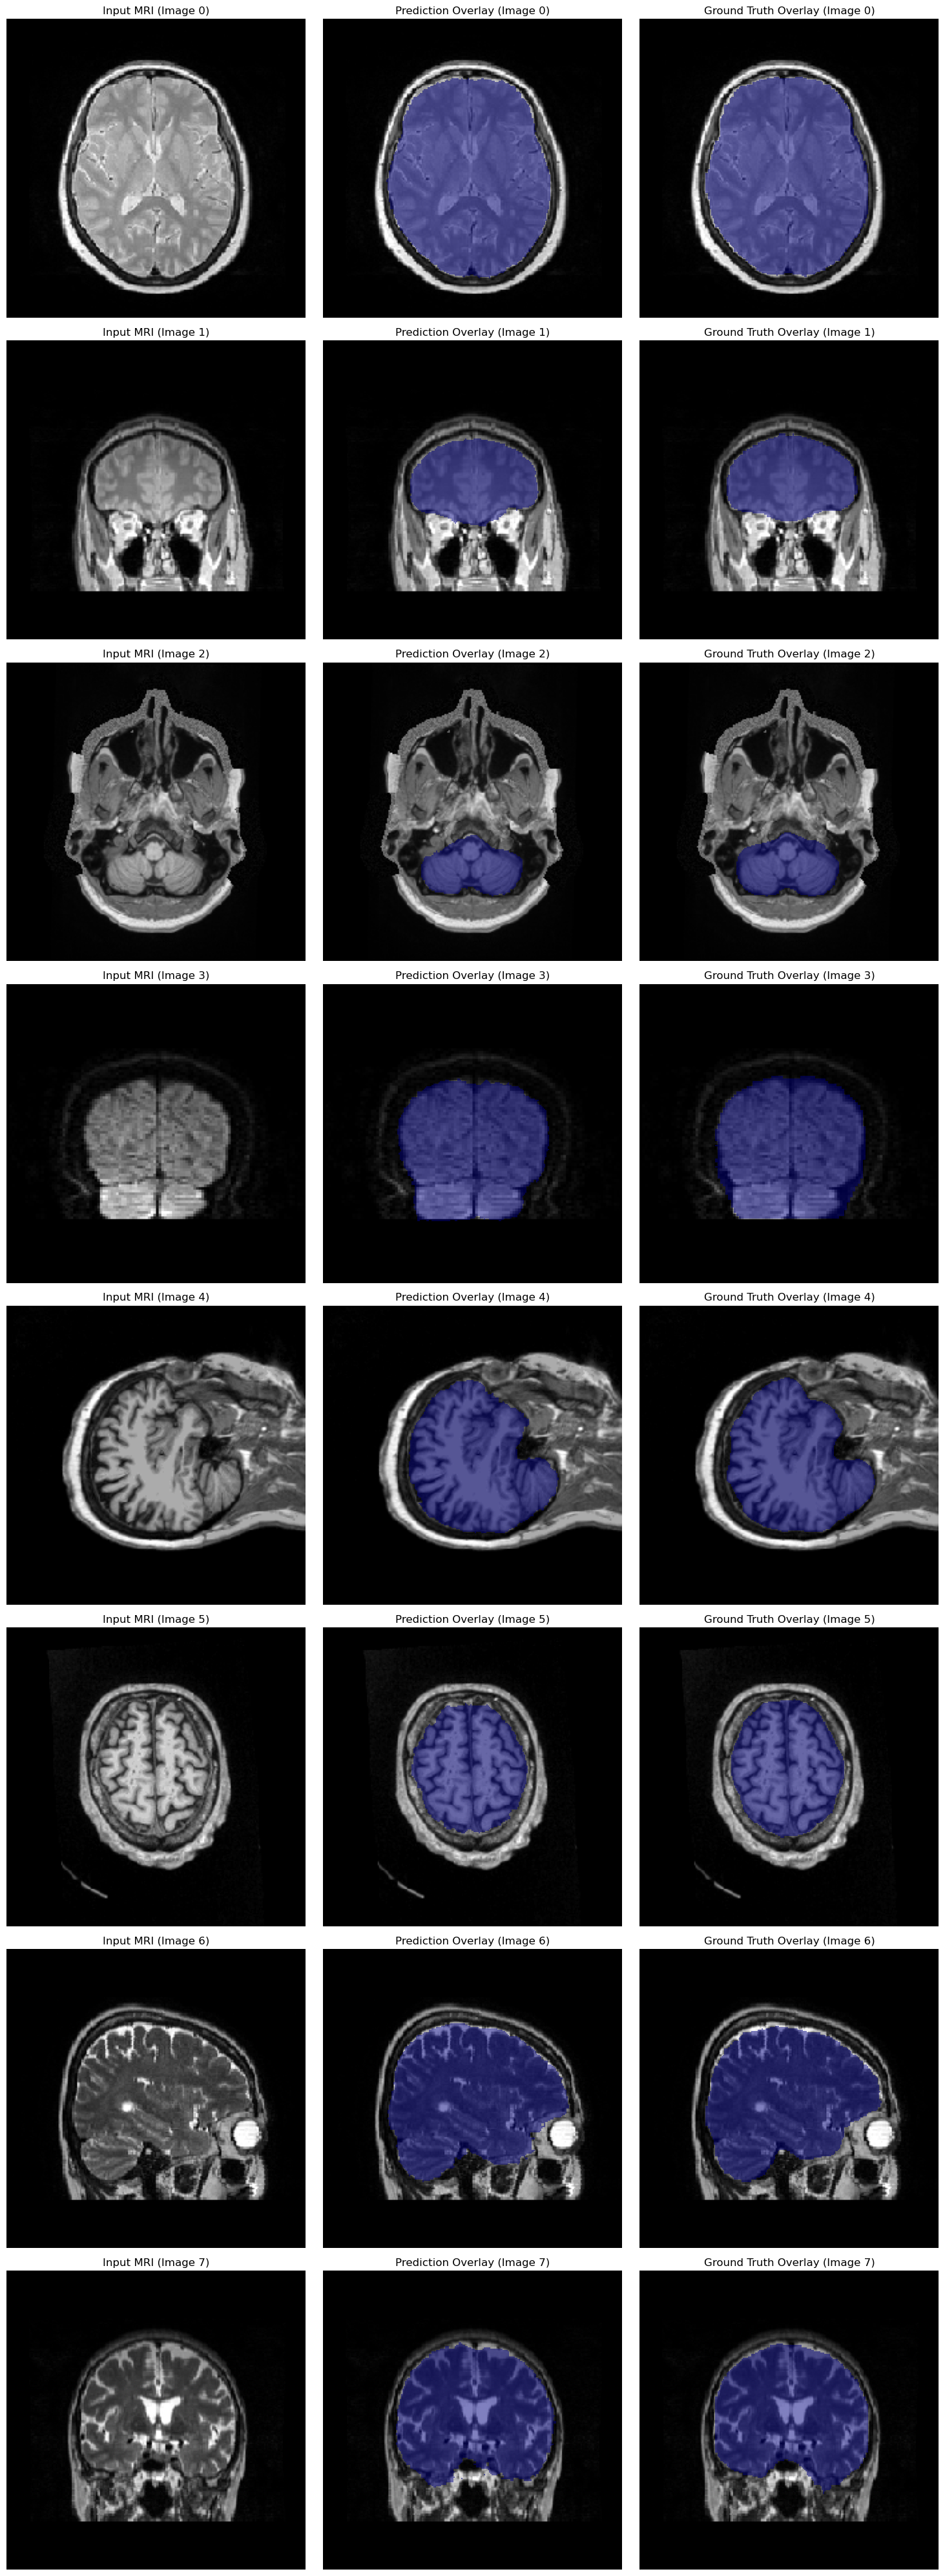

In [12]:
images = images.to(device)
logits = model(images.float())
pred_mask_masked, gt_mask_masked = plot_predictions_with_input(image_tensor, logits, masks,selected_classes = [1],max_plots=8)